# VoiceLens - Sentiment Model

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, TransformerMixin
import joblib
import json
import seaborn as sns
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from collections import Counter
import time
import re, os

## Constants

In [2]:
IS_ALL_DATA = False
project_id = 'wagon-bootcamp-2106'
dataset_id = 'voicelens'

data_review_and_rating_for_amazon_path = "https://storage.googleapis.com/voicelens/review-and-rating-for-amazon.csv"
data_trip_advisor_hotel_reviews_path = "https://storage.googleapis.com/voicelens/trip-advisor-hotel-reviews.csv"
data_trustpilot_reviews_dataset_path = "https://storage.googleapis.com/voicelens/trustpilot-reviews-dataset.csv"
data_amazon_product_reviews_path = "https://storage.googleapis.com/voicelens/amazon-product-reviews.csv"

## Main Dataframe

In [3]:
# Load the data with the working encoding
df = pd.read_csv(data_review_and_rating_for_amazon_path, encoding="latin-1")
df.head()

,name,n_review,country,comment,rating,date
0,Graham MOORE,21,GB,Uncaring and incompetent\r\r\n\r\r\nImpossible...,1,2022-06-20
1,popadog,5,GB,Amazon maybe the quickest way to get<U+0085>\r...,2,2022-06-20
2,Andrew Torok,6,US,Not fair!\r\r\n\r\r\nIn genera! I am an Amazon...,1,2022-06-20
3,Jerry Jocoy,15,US,Amazon Prime is crap\r\r\n\r\r\nAmazon Prime i...,1,2022-06-20
4,steve erickson,3,US,Terrible delivery services\r\r\n\r\r\nTerrible...,1,2022-06-19


In [4]:
# Create rating sentiment with text labels
def get_rating_sentiment(rating):
    if rating >= 4:
        return "positive"
    elif rating == 3:
        return "neutral"
    else:
        return "negative"

df['sentiment_rating'] = df['rating'].apply(get_rating_sentiment)

In [5]:
df.count()

name                12948
n_review            12948
country             12947
comment             12948
rating              12948
date                12948
sentiment_rating    12948
dtype: int64

In [6]:
if not IS_ALL_DATA:
    df = df.sample(n=1000, random_state=42)

## Preprocessing - Cleaning

In [7]:
# 4. Clean COMMENT column - REPLACE NEWLINES WITH SPACES
def clean_comment(comment):
    if pd.isna(comment):
        return ""

    if isinstance(comment, str):
        # Fix encoding issues first
        encoding_fixes = {
            'Ã¤': 'ä', 'Ã¶': 'ö', 'Ã¼': 'ü', 'ÃŸ': 'ß',
            'Ã©': 'é', 'Ã¢': 'â', 'Ã®': 'î', 'Ã´': 'ô',
            'Ã¡': 'á', 'Ã³': 'ó', 'Ãº': 'ú', 'Ã±': 'ñ',
            'Ã‰': 'É', 'Ã“': 'Ó', 'Ã‘': 'Ñ', 'Ã€': 'À',
            'Ãª': 'ê', 'Ã§': 'ç', 'Ã»': 'û', 'Ã¨': 'è',
            'Ã¬': 'ì', 'Ã²': 'ò', 'Ã¹': 'ù', 'Ã®': 'î'
        }

        for wrong, correct in encoding_fixes.items():
            comment = comment.replace(wrong, correct)

        # Remove Unicode escape sequences like <U+0085>
        comment = re.sub(r'<U\+\w+>', '', comment)

        # NORMALIZE LINE BREAKS - REPLACE ALL NEWLINES WITH SPACES
        comment = comment.replace('\r\r\n', ' ').replace('\r\n', ' ').replace('\n', ' ')

        # Remove extra whitespace (multiple spaces to single space)
        comment = re.sub(r'[ \t]+', ' ', comment)

        # Remove leading/trailing whitespace
        comment = comment.strip()

        # Remove any remaining non-printable characters except basic punctuation
        comment = re.sub(r'[^\x20-\x7EäöüßáéíóúñÁÉÍÓÚÑ]', '', comment)

        return comment

    return ""

# 5. Clean RATING column
def clean_rating(rating):
    if pd.isna(rating):
        return None

    try:
        # Handle string ratings
        if isinstance(rating, str):
            # Extract first numeric value
            match = re.search(r'(\d+)', rating)
            if match:
                rating = int(match.group(1))
            else:
                return None
        else:
            rating = int(float(rating))

        # Validate range
        if 1 <= rating <= 5:
            return rating
        else:
            return None

    except (ValueError, TypeError):
        return None


print("\n\nSTARTING COMPREHENSIVE DATA CLEANING")

print("Cleaning comment column...")
df['comment'] = df['comment'].apply(clean_comment)

print("Cleaning rating column...")
df['rating'] = df['rating'].apply(clean_rating)

# Remove rows with critical missing data
print(f"\nBefore cleaning: {len(df)} rows")



STARTING COMPREHENSIVE DATA CLEANING
Cleaning comment column...
Cleaning rating column...

Before cleaning: 1000 rows


In [8]:
# Create rating sentiment with text labels
def get_rating_sentiment(rating):
    if rating >= 4:
        return "positive"
    elif rating == 3:
        return "neutral"
    else:
        return "negative"

df['sentiment_rating'] = df['rating'].apply(get_rating_sentiment)

In [9]:

# Prepare Features and Target
X = df['comment']
y = df['sentiment_rating']

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

# Train-Test Split
print("\n\nSTEP 3: TRAIN-TEST SPLIT")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Features (X) shape: (1000,)
Target (y) shape: (1000,)


STEP 3: TRAIN-TEST SPLIT
Training set size: 800
Test set size: 200


## Models

In [10]:


def create_models():
    """
    Create and return a dictionary of model pipelines optimized for Amazon review sentiment analysis.

    Dataset Statistics:
    - negative: 7462
    - positive: 4897
    - neutral: 589

    """

    # TF-IDF configurations
    # Option 1: Standard TF-IDF (balanced approach)
    tfidf_standard = TfidfVectorizer(
        max_features=5000,        # Limit vocabulary size to prevent overfitting
        min_df=5,                 # Ignore terms that appear in less than 5 documents
        max_df=0.7,               # Ignore terms that appear in more than 70% of documents
        ngram_range=(1, 2),       # Include both unigrams and bigrams
        stop_words='english',     # Remove common English stop words
        lowercase=True,           # Convert all text to lowercase
        strip_accents='unicode'   # Remove accents and special characters
    )

    # Option 2: Enhanced TF-IDF (more features and trigrams)
    tfidf_enhanced = TfidfVectorizer(
        max_features=8000,        # Increased vocabulary size to capture more patterns
        min_df=3,                 # More inclusive - terms in at least 3 documents
        max_df=0.8,               # Slightly more inclusive for common terms
        ngram_range=(1, 3),       # Include unigrams, bigrams, and trigrams
        stop_words='english',
        lowercase=True,
        strip_accents='unicode',
        sublinear_tf=True         # Use 1 + log(tf) instead of raw term frequencies
    )

    models = {
        'logistic_regression': Pipeline([
            ('tfidf', tfidf_standard),
            ('classifier', LogisticRegression(
                random_state=42,   # Seed for reproducibility
                max_iter=1000,     # Ensure convergence with more iterations
                class_weight='balanced', # REMOVED: 'balanced' was causing over-weighting of minority class
                C=1.0,            # Regularization strength - inverse of regularization
                # REMOVED: 'multi_class' parameter (deprecated in sklearn 1.5+)
                solver='lbfgs'     # Good solver for multiclass problems
            ))
        ]),

        'logistic_regression_enhanced': Pipeline([
            ('tfidf', tfidf_enhanced),
            ('classifier', LogisticRegression(
                random_state=42,
                max_iter=1000,
                class_weight='balanced',
                C=0.5,            # Stronger regularization for larger feature space
                solver='lbfgs'
            ))
        ]),

        'random_forest': Pipeline([
            ('tfidf', tfidf_standard),
            ('classifier', RandomForestClassifier(
                n_estimators=100,   # Number of trees in the forest
                random_state=42,
                class_weight='balanced',  # REMOVED: Avoid over-weighting small neutral class
                min_samples_split=20,  # Regularization: require more samples to split
                min_samples_leaf=10,   # Regularization: require more samples per leaf
                max_depth=None,     # Let trees grow fully (can also try limiting)
                bootstrap=True      # Use bootstrap sampling
            ))
        ]),

        'svm_linear': Pipeline([
            ('tfidf', tfidf_standard),
            ('classifier', SVC(
                random_state=42,
                class_weight='balanced',  # REMOVED: Balanced weighting was problematic
                probability=True,   # Enable probability estimates for evaluation
                kernel='linear',    # Linear kernel works well with high-dimensional text data
                C=1.0,             # Regularization parameter
                gamma='scale'       # Kernel coefficient for non-linear kernels
            ))
        ]),

        'svm_rbf': Pipeline([
            ('tfidf', tfidf_standard),
            ('classifier', SVC(
                random_state=42,
                class_weight='balanced',
                probability=True,
                kernel='rbf',      # Non-linear kernel for complex patterns
                C=1.0,
                gamma='scale'      # Automatic kernel coefficient scaling
            ))
        ]),

        'naive_bayes': Pipeline([
            ('tfidf', tfidf_standard),
            ('classifier', MultinomialNB(
                alpha=0.1,         # Additive (Laplace/Lidstone) smoothing parameter
                fit_prior=True     # Learn class prior probabilities from data
            ))
        ]),

        'naive_bayes_enhanced': Pipeline([
            ('tfidf', tfidf_enhanced),
            ('classifier', MultinomialNB(
                alpha=0.5,         # Stronger smoothing for larger feature space
                fit_prior=True
            ))
        ]),

        'neural_network_fixed': Pipeline([
            ('tfidf', tfidf_standard),
            ('classifier', MLPClassifier(
                hidden_layer_sizes=(100,),  # Single hidden layer with 100 neurons
                random_state=42,
                early_stopping=False,       # DISABLED: Causing dtype issues with sparse matrices
                alpha=0.001,                # L2 regularization parameter
                learning_rate='adaptive',   # Adjust learning rate during training
                max_iter=500,               # Maximum number of iterations
                batch_size=256,             # Larger batch size for stability
                tol=1e-4                    # Tolerance for optimization
            ))
        ])
    }
    return models

## Functions

In [11]:
def train_and_evaluate_model(model_name, pipeline, X_train, y_train, X_test, y_test):
    """Train and evaluate a single model"""
    print(f"🚀 Training {model_name}...")
    start_time = time.time()

    # Train model
    pipeline.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test) if hasattr(pipeline, 'predict_proba') else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)

    # Get classification report as dict
    report_dict = classification_report(y_test, y_pred, output_dict=True)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Make predictions on full dataset
    full_predictions = pipeline.predict(X)

    print(f"✅ {model_name} completed in {training_time:.2f}s")

    return {
        'model_name': model_name,
        'pipeline': pipeline,
        'accuracy': accuracy,
        'training_time': training_time,
        'predictions': y_pred.tolist(),
        'prediction_probabilities': y_pred_proba.tolist() if y_pred_proba is not None else None,
        'classification_report': report_dict,
        'confusion_matrix': cm.tolist(),
        'full_dataset_predictions': full_predictions.tolist()
    }


In [12]:
def run_models_in_parallel(models, X_train, y_train, X_test, y_test, X_full):
    """Run all models in parallel and collect results"""
    print("\n\nSTEP 4: RUNNING MODELS IN PARALLEL")
    results = {}

    with ThreadPoolExecutor(max_workers=len(models)) as executor:
        # Submit all tasks
        future_to_model = {
            executor.submit(train_and_evaluate_model, name, model, X_train, y_train, X_test, y_test): name
            for name, model in models.items()
        }

        # Collect results as they complete
        for future in as_completed(future_to_model):
            model_name = future_to_model[future]
            try:
                result = future.result()
                results[model_name] = result
            except Exception as exc:
                print(f"❌ {model_name} generated an exception: {exc}")
                results[model_name] = {'error': str(exc)}

    return results


In [13]:
def consolidate_results_to_json(model_results, df, X_test_indices):
    """Consolidate all model results into a comprehensive JSON response"""

    # Find best model
    best_model_name = max(
        [(name, result['accuracy']) for name, result in model_results.items() if 'accuracy' in result],
        key=lambda x: x[1]
    )[0]
    best_model = model_results[best_model_name]

    # Create consolidated JSON structure
    consolidated_json = {
        'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
        'dataset_info': {
            'total_samples': len(df),
            'training_samples': len(X_train),
            'test_samples': len(X_test),
            'sentiment_distribution': df['sentiment_rating'].value_counts().to_dict()
        },
        'model_comparison': {
            'best_model': best_model_name,
            'models': {}
        },
        'predictions': {
            'best_model_predictions': best_model['full_dataset_predictions'],
            'all_models_predictions': {}
        },
        'test_set_results': {}
    }

    # Add individual model results
    for model_name, result in model_results.items():
        if 'accuracy' in result:
            consolidated_json['model_comparison']['models'][model_name] = {
                'accuracy': result['accuracy'],
                'training_time': result['training_time'],
                'precision': result['classification_report']['weighted avg']['precision'],
                'recall': result['classification_report']['weighted avg']['recall'],
                'f1_score': result['classification_report']['weighted avg']['f1-score']
            }

            # Add predictions for each model
            consolidated_json['predictions']['all_models_predictions'][model_name] = result['full_dataset_predictions']

    # Add test set details with actual vs predicted for best model
    test_indices_list = X_test_indices.tolist()
    consolidated_json['test_set_results'] = {
        'test_indices': test_indices_list,
        'actual_sentiments': y_test.tolist(),
        'best_model_predictions': best_model['predictions'],
        'comparison': []
    }

    # Add sample comparisons
    for i, idx in enumerate(test_indices_list[:10]):  # First 10 test samples
        consolidated_json['test_set_results']['comparison'].append({
            'review_id': int(idx),
            'comment': df.loc[idx, 'comment'][:100] + '...',  # First 100 chars
            'actual_sentiment': y_test.iloc[i],
            'predicted_sentiment': best_model['predictions'][i]
        })

    return consolidated_json


## Main best model

In [ ]:
# Main execution
if __name__ == "__main__":
    # Create models
    models = create_models()

    # Run models in parallel
    model_results = run_models_in_parallel(models, X_train, y_train, X_test, y_test, X)

    # Consolidate results
    print("\n\nSTEP 5: CONSOLIDATING RESULTS")
    X_test_indices = X_test.index  # Get original indices of test set

    consolidated_json = consolidate_results_to_json(model_results, df, X_test_indices)


    # Save JSON results with dataset-specific name
    output_json_path = f"./model_comparison_results.json"
    with open(output_json_path, 'w', encoding='utf-8') as f:
        json.dump(consolidated_json, f, indent=2, ensure_ascii=False)

    print(f"✅ Consolidated results saved to: {output_json_path}")

    # Save best model with dataset-specific name
    best_model_name = consolidated_json['model_comparison']['best_model']
    best_model_pipeline = model_results[best_model_name]['pipeline']
    best_model_filename = f"best_model_{best_model_name}.pkl"
    joblib.dump(best_model_pipeline, best_model_filename)
    print(f"✅ Best model ({best_model_name}) saved as: {best_model_filename}")

    # Add best model predictions to dataframe
    df['predicted_sentiment_best_model'] = model_results[best_model_name]['full_dataset_predictions']

    # Save updated dataset with dataset-specific name
    updated_dataset_path = f"./dataset_with_predictions.csv"
    df.to_csv(updated_dataset_path, encoding='utf-8', index=False)
    print(f"✅ Updated dataset with all predictions saved as: {updated_dataset_path}")

    # Store dataset info in JSON for tracking
    consolidated_json['dataset_info'] = {
        'best_model': best_model_name,
        'output_files': {
            'json_results': output_json_path,
            'best_model': best_model_filename,
            'updated_dataset': updated_dataset_path
        }
    }

    # Update JSON with dataset info
    with open(output_json_path, 'w', encoding='utf-8') as f:
        json.dump(consolidated_json, f, indent=2, ensure_ascii=False)

    print("\n\n🚀 PARALLEL MODEL TRAINING COMPLETED!")
    print(f"🏆 Best Model: {best_model_name}")
    print(f"📁 Results: {output_json_path}")
    print(f"📁 Best model: {best_model_filename}")
    print(f"📁 Updated dataset: {updated_dataset_path}")



STEP 4: RUNNING MODELS IN PARALLEL
🚀 Training logistic_regression...
🚀 Training logistic_regression_enhanced...
🚀 Training random_forest...
🚀 Training svm_linear...
🚀 Training svm_rbf...
🚀 Training naive_bayes...
🚀 Training naive_bayes_enhanced...
🚀 Training neural_network_fixed...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ naive_bayes completed in 1.32s
✅ naive_bayes_enhanced completed in 1.47s
✅ logistic_regression completed in 2.31s
✅ logistic_regression_enhanced completed in 2.32s
✅ svm_linear completed in 3.77s
✅ svm_rbf completed in 4.42s
✅ random_forest completed in 5.00s
✅ neural_network_fixed completed in 8.64s


STEP 5: CONSOLIDATING RESULTS
✅ Consolidated results saved to: ./model_comparison_results.json
✅ Best model (naive_bayes) saved as: best_model_naive_bayes.pkl
✅ Updated dataset with all predictions saved as: ./dataset_with_predictions.csv


🚀 PARALLEL MODEL TRAINING COMPLETED!
🏆 Best Model: naive_bayes
📁 Results: ./model_comparison_results.json
📁 Best model: best_model_naive_bayes.pkl
📁 Updated dataset: ./dataset_with_predictions.csv


## Main all models

In [ ]:
import os
import json
import joblib

# Main execution
if __name__ == "__main__":
    # Create directories if they don't exist
    os.makedirs('../models', exist_ok=True)
    os.makedirs('./raw_data', exist_ok=True)

    # Create models
    models = create_models()

    # Run models in parallel
    model_results = run_models_in_parallel(models, X_train, y_train, X_test, y_test, X)

    # Consolidate results
    print("\n\nSTEP 5: CONSOLIDATING RESULTS")
    X_test_indices = X_test.index  # Get original indices of test set

    consolidated_json = consolidate_results_to_json(model_results, df, X_test_indices)

    # Save JSON results in raw_data directory
    output_json_path = f"./raw_data/model_comparison_results.json"
    with open(output_json_path, 'w', encoding='utf-8') as f:
        json.dump(consolidated_json, f, indent=2, ensure_ascii=False)

    print(f"✅ Consolidated results saved to: {output_json_path}")

    # Debug: Print the structure of consolidated_json to understand the actual keys
    print("🔍 Debug - consolidated_json keys:", consolidated_json.keys())
    if 'model_comparison' in consolidated_json:
        print("🔍 Debug - model_comparison keys:", consolidated_json['model_comparison'].keys())

    # Save ALL models with their metadata in models directory
    saved_models_info = {}

    # Get model performance data from the correct structure
    # Try different possible structures
    model_performance = None

    if 'model_comparison' in consolidated_json:
        model_comparison = consolidated_json['model_comparison']
        # Try different possible keys for model performance data
        if 'model_performance' in model_comparison:
            model_performance = model_comparison['model_performance']
        elif 'models' in model_comparison:
            model_performance = model_comparison['models']
        elif 'performance' in model_comparison:
            model_performance = model_comparison['performance']
        else:
            # If none of the expected keys exist, use the model_comparison dict itself
            model_performance = model_comparison
    else:
        # If no model_comparison key, use the root level
        model_performance = consolidated_json

    print(f"🔍 Using model performance data with {len(model_performance)} models")

    # Save all models in models directory
    for i, model_name in enumerate(model_results.keys(), 1):
        try:
            # Get accuracy from the performance data
            if model_name in model_performance:
                accuracy = model_performance[model_name].get('accuracy', 0.0)
            else:
                # Fallback: try to get accuracy from model_results
                accuracy = model_results[model_name].get('test_accuracy', 0.0)

            # Create model filename with accuracy and order
            model_filename = f"model_{i:02d}_{model_name}_acc_{accuracy:.4f}.pkl"
            model_filepath = f"../models/{model_filename}"

            # Save the model
            model_pipeline = model_results[model_name]['pipeline']
            joblib.dump(model_pipeline, model_filepath)

            # Handle predictions - they might already be lists
            full_predictions = model_results[model_name]['full_dataset_predictions']

            # Store model info
            saved_models_info[model_name] = {
                'filename': model_filename,
                'filepath': model_filepath,
                'order': i,
                'accuracy': accuracy,
                'full_predictions': full_predictions  # Use as-is, don't call tolist()
            }

            print(f"✅ Model {i}: {model_name} (acc: {accuracy:.4f}) saved as: {model_filepath}")

        except Exception as e:
            print(f"❌ Error saving model {model_name}: {e}")
            import traceback
            traceback.print_exc()

    # Save best model separately for easy access in models directory
    best_model_name = consolidated_json.get('model_comparison', {}).get('best_model', list(model_results.keys())[0])
    best_model_filename = f"best_model_{best_model_name}.pkl"
    best_model_filepath = f"../models/{best_model_filename}"
    joblib.dump(model_results[best_model_name]['pipeline'], best_model_filepath)
    print(f"✅ Best model ({best_model_name}) saved as: {best_model_filepath}")

    # Add best model predictions to dataframe
    df['predicted_sentiment_best_model'] = model_results[best_model_name]['full_dataset_predictions']

    # Save updated dataset in raw_data directory
    updated_dataset_path = f"./raw_data/dataset_with_predictions.csv"
    df.to_csv(updated_dataset_path, encoding='utf-8', index=False)
    print(f"✅ Updated dataset with all predictions saved as: {updated_dataset_path}")

    # Store dataset info in JSON for tracking
    consolidated_json['dataset_info'] = {
        'best_model': best_model_name,
        'saved_models': saved_models_info,
        'output_files': {
            'json_results': output_json_path,
            'best_model': best_model_filepath,
            'updated_dataset': updated_dataset_path,
            'all_models': list(saved_models_info.values())
        }
    }

    # Update JSON with dataset info
    with open(output_json_path, 'w', encoding='utf-8') as f:
        json.dump(consolidated_json, f, indent=2, ensure_ascii=False)

    print("\n\n🚀 PARALLEL MODEL TRAINING COMPLETED!")
    print(f"🏆 Best Model: {best_model_name}")
    print(f"📊 Total Models Saved: {len(saved_models_info)}")
    print(f"📁 Results JSON: {output_json_path}")
    print(f"📁 Best model: {best_model_filepath}")
    print(f"📁 Updated dataset: {updated_dataset_path}")
    print(f"📁 All models saved in ../models/ directory")
    print(f"📁 CSV and JSON files saved in ./raw_data/ directory")

    # Print directory structure
    print("\n📁 FINAL DIRECTORY STRUCTURE:")
    print("├── models/")
    for model_info in saved_models_info.values():
        print(f"│   ├── {model_info['filename']}")
    print(f"│   └── {best_model_filename}")
    print("└── raw_data/")
    print(f"    ├── model_comparison_results.json")
    print(f"    └── dataset_with_predictions.csv")



STEP 4: RUNNING MODELS IN PARALLEL
🚀 Training logistic_regression...
🚀 Training logistic_regression_enhanced...
🚀 Training random_forest...
🚀 Training svm_linear...
🚀 Training svm_rbf...
🚀 Training naive_bayes...
🚀 Training naive_bayes_enhanced...
🚀 Training neural_network_fixed...


/home/userf/.pyenv/versions/3.10.6/envs/voicelens/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/userf/.pyenv/versions/3.10.6/envs/voicelens/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/userf/.pyenv/versions/3.10.6/envs/voicelens/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavio

✅ naive_bayes completed in 3.00s
✅ naive_bayes_enhanced completed in 3.37s
✅ logistic_regression completed in 4.52s
✅ svm_linear completed in 4.55s
✅ logistic_regression_enhanced completed in 4.64s
✅ svm_rbf completed in 5.20s
✅ random_forest completed in 6.39s
✅ neural_network_fixed completed in 11.09s


STEP 5: CONSOLIDATING RESULTS
✅ Consolidated results saved to: ./raw_data/model_comparison_results.json
🔍 Debug - consolidated_json keys: dict_keys(['timestamp', 'dataset_info', 'model_comparison', 'predictions', 'test_set_results'])
🔍 Debug - model_comparison keys: dict_keys(['best_model', 'models'])
🔍 Using model performance data with 8 models
✅ Model 1: naive_bayes (acc: 0.8750) saved as: ../models/model_01_naive_bayes_acc_0.8750.pkl
✅ Model 2: naive_bayes_enhanced (acc: 0.8700) saved as: ../models/model_02_naive_bayes_enhanced_acc_0.8700.pkl
✅ Model 3: logistic_regression (acc: 0.8700) saved as: ../models/model_03_logistic_regression_acc_0.8700.pkl
✅ Model 4: svm_linear (acc: 0.86

## Visualisation



📊 COMPREHENSIVE MODEL ANALYSIS:


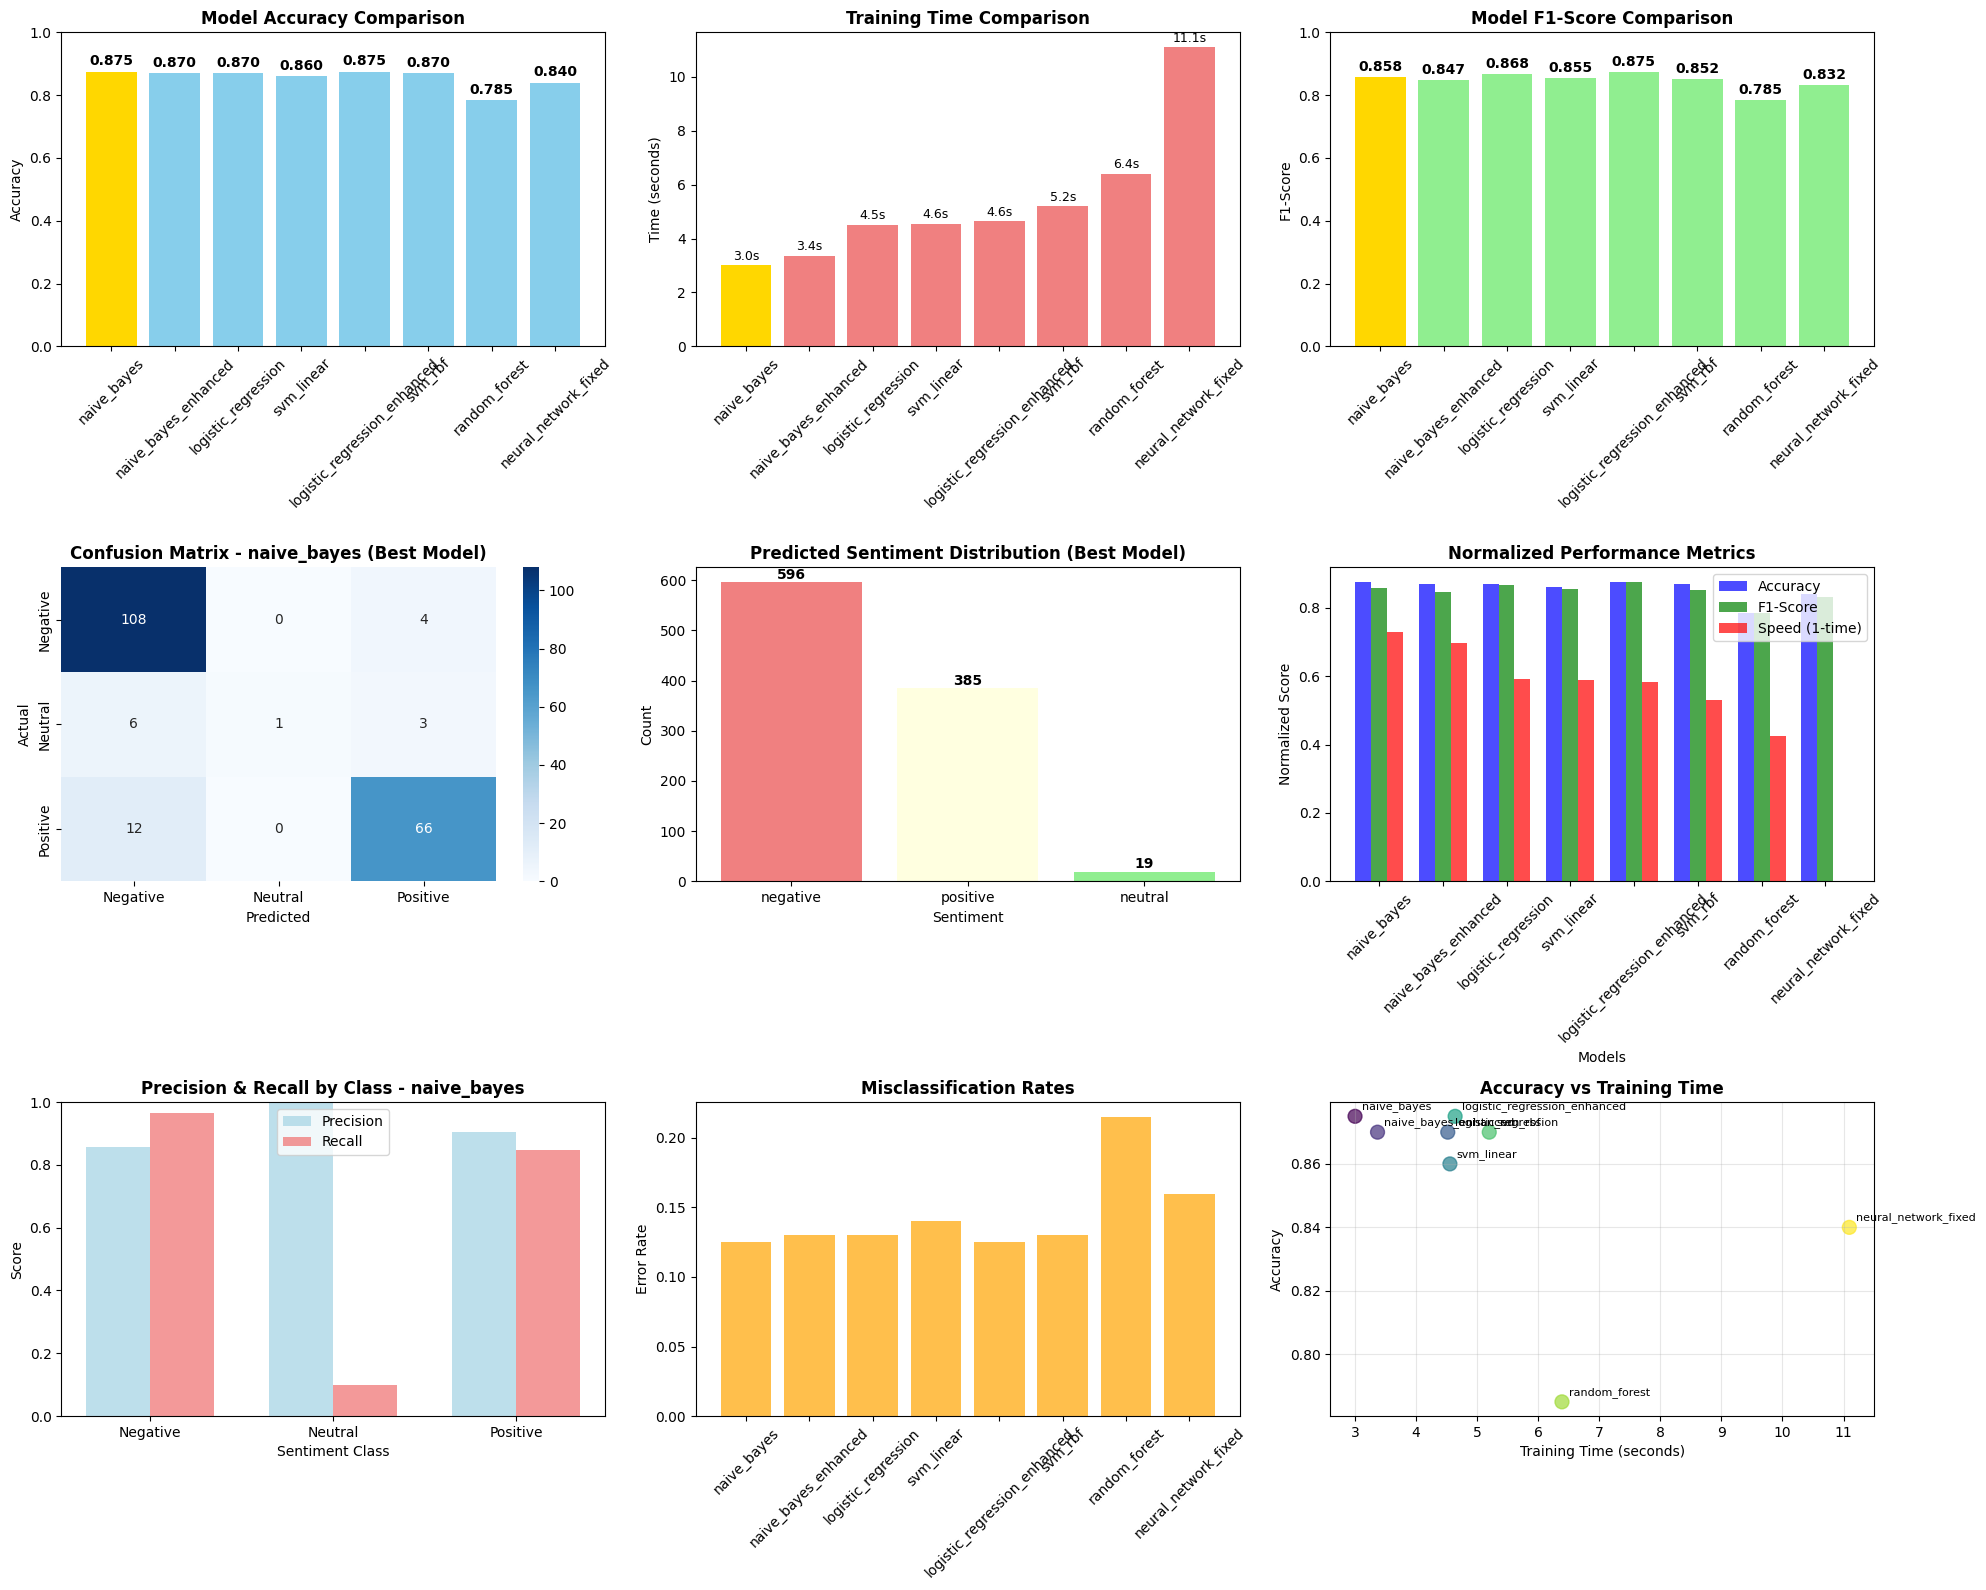


📊 DETAILED MODEL ANALYSIS


📊 MODEL COMPARISON SUMMARY:
naive_bayes ★:
  Accuracy:  0.8750
  F1-Score:  0.8583
  Time:      3.00s

naive_bayes_enhanced:
  Accuracy:  0.8700
  F1-Score:  0.8469
  Time:      3.37s

logistic_regression:
  Accuracy:  0.8700
  F1-Score:  0.8678
  Time:      4.52s

svm_linear:
  Accuracy:  0.8600
  F1-Score:  0.8555
  Time:      4.55s

logistic_regression_enhanced:
  Accuracy:  0.8750
  F1-Score:  0.8746
  Time:      4.64s

svm_rbf:
  Accuracy:  0.8700
  F1-Score:  0.8524
  Time:      5.20s

random_forest:
  Accuracy:  0.7850
  F1-Score:  0.7850
  Time:      6.39s

neural_network_fixed:
  Accuracy:  0.8400
  F1-Score:  0.8320
  Time:      11.09s


🎯 BEST MODEL: naive_bayes
   Accuracy: 0.8750
   F1-Score: 0.8583
   Training Time: 3.00s

📋 CONFUSION MATRIX ANALYSIS:
   Negative: 108/112 correct (96.4%)
   Neutral: 1/10 correct (10.0%)
   Positive: 66/78 correct (84.6%)

📈 PER-CLASS METRICS:
   Negative: Precision=0.857, Recall=0.964, F1=0.908
   Neutral: Pre

In [16]:
def create_comprehensive_visualizations(consolidated_json, model_results, best_model_name, df):
    """
    Create comprehensive visualizations and analysis for all models
    """

    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(20, 16))


    # 1. Model Accuracy Comparison
    plt.subplot(3, 3, 1)
    model_names = list(consolidated_json['model_comparison']['models'].keys())
    accuracies = [consolidated_json['model_comparison']['models'][m]['accuracy'] for m in model_names]
    colors = ['gold' if m == best_model_name else 'skyblue' for m in model_names]
    bars = plt.bar(model_names, accuracies, color=colors)
    plt.title('Model Accuracy Comparison', fontweight='bold')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    plt.ylim(0, 1.0)

    # 2. Training Time Comparison
    plt.subplot(3, 3, 2)
    training_times = [consolidated_json['model_comparison']['models'][m]['training_time'] for m in model_names]
    colors = ['gold' if m == best_model_name else 'lightcoral' for m in model_names]
    bars = plt.bar(model_names, training_times, color=colors)
    plt.title('Training Time Comparison', fontweight='bold')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45)
    # Add value labels on bars
    for bar, time_val in zip(bars, training_times):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{time_val:.1f}s', ha='center', va='bottom', fontsize=9)

    # 3. F1-Score Comparison
    plt.subplot(3, 3, 3)
    f1_scores = [consolidated_json['model_comparison']['models'][m]['f1_score'] for m in model_names]
    colors = ['gold' if m == best_model_name else 'lightgreen' for m in model_names]
    bars = plt.bar(model_names, f1_scores, color=colors)
    plt.title('Model F1-Score Comparison', fontweight='bold')
    plt.ylabel('F1-Score')
    plt.xticks(rotation=45)
    # Add value labels on bars
    for bar, f1 in zip(bars, f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')
    plt.ylim(0, 1.0)

    # 4. Confusion Matrix for Best Model
    plt.subplot(3, 3, 4)
    best_model_cm = np.array(model_results[best_model_name]['confusion_matrix'])
    sns.heatmap(best_model_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title(f'Confusion Matrix - {best_model_name} (Best Model)', fontweight='bold')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    # 5. Sentiment Distribution - Best Model Predictions
    plt.subplot(3, 3, 5)
    sentiment_counts = df['predicted_sentiment_best_model'].value_counts()
    colors = ['lightcoral', 'lightyellow', 'lightgreen']
    bars = plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors)
    plt.title('Predicted Sentiment Distribution (Best Model)', fontweight='bold')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    # Add value labels on bars
    for bar, count in zip(bars, sentiment_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{count}', ha='center', va='bottom', fontweight='bold')

    # 6. Model Performance Radar Chart (Accuracy, F1, Speed)
    plt.subplot(3, 3, 6)
    # Normalize metrics for radar chart
    max_time = max(training_times)
    normalized_times = [1 - (t / max_time) for t in training_times]  # Inverse since lower time is better
    normalized_acc = accuracies  # Already 0-1
    normalized_f1 = f1_scores    # Already 0-1

    # Simple bar comparison instead of radar for clarity
    metrics_comparison = np.array([normalized_acc, normalized_f1, normalized_times])
    x_pos = np.arange(len(model_names))
    width = 0.25

    for i, (metric, label, color) in enumerate(zip(
        metrics_comparison, ['Accuracy', 'F1-Score', 'Speed (1-time)'], ['blue', 'green', 'red']
    )):
        plt.bar(x_pos + i*width, metric, width, label=label, alpha=0.7, color=color)

    plt.xlabel('Models')
    plt.ylabel('Normalized Score')
    plt.title('Normalized Performance Metrics', fontweight='bold')
    plt.xticks(x_pos + width, model_names, rotation=45)
    plt.legend()

    # 7. Precision-Recall Comparison by Class (for best model)
    plt.subplot(3, 3, 7)
    # Calculate precision, recall, f1 for each class
    cm = best_model_cm
    precision_per_class = []
    recall_per_class = []

    for i in range(3):
        precision = cm[i,i] / cm[:,i].sum() if cm[:,i].sum() > 0 else 0
        recall = cm[i,i] / cm[i,:].sum() if cm[i,:].sum() > 0 else 0
        precision_per_class.append(precision)
        recall_per_class.append(recall)

    classes = ['Negative', 'Neutral', 'Positive']
    x = np.arange(len(classes))
    width = 0.35

    plt.bar(x - width/2, precision_per_class, width, label='Precision', alpha=0.8, color='lightblue')
    plt.bar(x + width/2, recall_per_class, width, label='Recall', alpha=0.8, color='lightcoral')

    plt.xlabel('Sentiment Class')
    plt.ylabel('Score')
    plt.title(f'Precision & Recall by Class - {best_model_name}', fontweight='bold')
    plt.xticks(x, classes)
    plt.legend()
    plt.ylim(0, 1.0)

    # 8. Error Analysis - Misclassification Patterns
    plt.subplot(3, 3, 8)
    # Calculate misclassification rates
    misclassification_rates = []
    for model_name in model_names:
        cm = np.array(model_results[model_name]['confusion_matrix'])
        total = cm.sum()
        correct = np.trace(cm)
        misclassification_rates.append((total - correct) / total)

    plt.bar(model_names, misclassification_rates, color='orange', alpha=0.7)
    plt.title('Misclassification Rates', fontweight='bold')
    plt.ylabel('Error Rate')
    plt.xticks(rotation=45)

    # 9. Performance vs Time Scatter Plot
    plt.subplot(3, 3, 9)
    scatter = plt.scatter(training_times, accuracies, s=100, alpha=0.7, c=range(len(model_names)), cmap='viridis')

    # Annotate points with model names
    for i, (time, acc, name) in enumerate(zip(training_times, accuracies, model_names)):
        plt.annotate(name, (time, acc), xytext=(5, 5), textcoords='offset points', fontsize=8)

    plt.xlabel('Training Time (seconds)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Training Time', fontweight='bold')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print detailed analysis
    print_detailed_analysis(consolidated_json, model_results, best_model_name, df)

def print_detailed_analysis(consolidated_json, model_results, best_model_name, df):
    """
    Print detailed analysis of model performance
    """
    print("\n" + "="*80)
    print("📊 DETAILED MODEL ANALYSIS")
    print("="*80)

    # Best model detailed analysis
    best_model_metrics = consolidated_json['model_comparison']['models'][best_model_name]
    best_model_cm = np.array(model_results[best_model_name]['confusion_matrix'])


################################
    # Print summary
    print("\n\n📊 MODEL COMPARISON SUMMARY:")
    print("=" * 50)
    for model_name, metrics in consolidated_json['model_comparison']['models'].items():
        star = " ★" if model_name == best_model_name else ""
        print(f"{model_name}{star}:")
        print(f"  Accuracy:  {metrics['accuracy']:.4f}")
        print(f"  F1-Score:  {metrics['f1_score']:.4f}")
        print(f"  Time:      {metrics['training_time']:.2f}s")
        print()
##################################

    print(f"\n🎯 BEST MODEL: {best_model_name}")
    print(f"   Accuracy: {best_model_metrics['accuracy']:.4f}")
    print(f"   F1-Score: {best_model_metrics['f1_score']:.4f}")
    print(f"   Training Time: {best_model_metrics['training_time']:.2f}s")

    # Confusion matrix analysis
    print(f"\n📋 CONFUSION MATRIX ANALYSIS:")
    classes = ['Negative', 'Neutral', 'Positive']
    for i, actual_class in enumerate(classes):
        total_actual = best_model_cm[i].sum()
        correct = best_model_cm[i,i]
        accuracy_per_class = correct / total_actual if total_actual > 0 else 0
        print(f"   {actual_class}: {correct}/{total_actual} correct ({accuracy_per_class:.1%})")

    # Precision, Recall, F1 per class
    print(f"\n📈 PER-CLASS METRICS:")
    for i, class_name in enumerate(classes):
        precision = best_model_cm[i,i] / best_model_cm[:,i].sum() if best_model_cm[:,i].sum() > 0 else 0
        recall = best_model_cm[i,i] / best_model_cm[i,:].sum() if best_model_cm[i,:].sum() > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        print(f"   {class_name}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

    # Model ranking
    print(f"\n🏆 MODEL RANKING BY ACCURACY:")
    models_ranked = sorted(
        consolidated_json['model_comparison']['models'].items(),
        key=lambda x: x[1]['accuracy'],
        reverse=True
    )
    for rank, (model_name, metrics) in enumerate(models_ranked, 1):
        star = " ★" if model_name == best_model_name else ""
        print(f"   {rank}. {model_name}{star}: {metrics['accuracy']:.4f} (F1: {metrics['f1_score']:.4f})")

    # Sentiment distribution
    print(f"\n📊 SENTIMENT DISTRIBUTION (Best Model Predictions):")
    sentiment_counts = df['predicted_sentiment_best_model'].value_counts()
    total_reviews = len(df)
    for sentiment, count in sentiment_counts.items():
        percentage = (count / total_reviews) * 100
        print(f"   {sentiment}: {count} reviews ({percentage:.1f}%)")

    # Performance insights
    print(f"\n💡 PERFORMANCE INSIGHTS:")
    fastest_model = min(consolidated_json['model_comparison']['models'].items(),
                       key=lambda x: x[1]['training_time'])[0]
    highest_f1 = max(consolidated_json['model_comparison']['models'].items(),
                    key=lambda x: x[1]['f1_score'])[0]


    model_names = list(consolidated_json['model_comparison']['models'].keys())
    training_times = [consolidated_json['model_comparison']['models'][m]['training_time'] for m in model_names]

    accuracies = [consolidated_json['model_comparison']['models'][m]['accuracy'] for m in model_names]


    print(f"   • Fastest model: {fastest_model} ({consolidated_json['model_comparison']['models'][fastest_model]['training_time']:.2f}s)")
    print(f"   • Highest F1-score: {highest_f1} ({consolidated_json['model_comparison']['models'][highest_f1]['f1_score']:.4f})")
    print(f"   • Accuracy range: {min(accuracies):.4f} - {max(accuracies):.4f}")
    print(f"   • Time range: {min(training_times):.2f}s - {max(training_times):.2f}s")

# Replace your current visualization section with:
print("\n\n📊 COMPREHENSIVE MODEL ANALYSIS:")
print("=" * 60)

# Create comprehensive visualizations
create_comprehensive_visualizations(consolidated_json, model_results, best_model_name, df)

print(f"\n🎯 Best Model: {best_model_name}")
print(f"📈 Best Accuracy: {consolidated_json['model_comparison']['models'][best_model_name]['accuracy']:.4f}")

## GPU later